In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df =pd.read_csv("data/GlobalLandTemperaturesByMajorCity.csv")

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int8)
    return df
df = downcast_dtypes(df)


In [4]:
#df.isnull().sum()
df.set_index(keys="dt", inplace=True)

## Baseline: ARIMA MODEL

### So what exactly is an ARIMA model?

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that 

is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

### What does the p, d and q in ARIMA model mean?

The first step to build an ARIMA model is to make the time series stationary.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

Next, what are the ‘p’ and ‘q’ terms?

‘p’ is the order of the ‘Auto Regressive’ (AR) term. 

It refers to the number of lags of Y to be used as predictors.

 And ‘q’ is the order of the ‘Moving Average’ (MA) term.
 
  It refers to the number of lagged forecast errors that should go into the ARIMA Model.

### How to find out p, d et q

In [13]:
# First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
# The null hypothesis is non- stationary

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df["AverageTemperature"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.346705
p-value: 0.000000


Since P-value is less than (0.05) we faced non-stationary situation.

W'll use ACF( Autocorrelation function) and PACF ( Partial autocorrelation) to try to figure out ARIMA  orders parameters

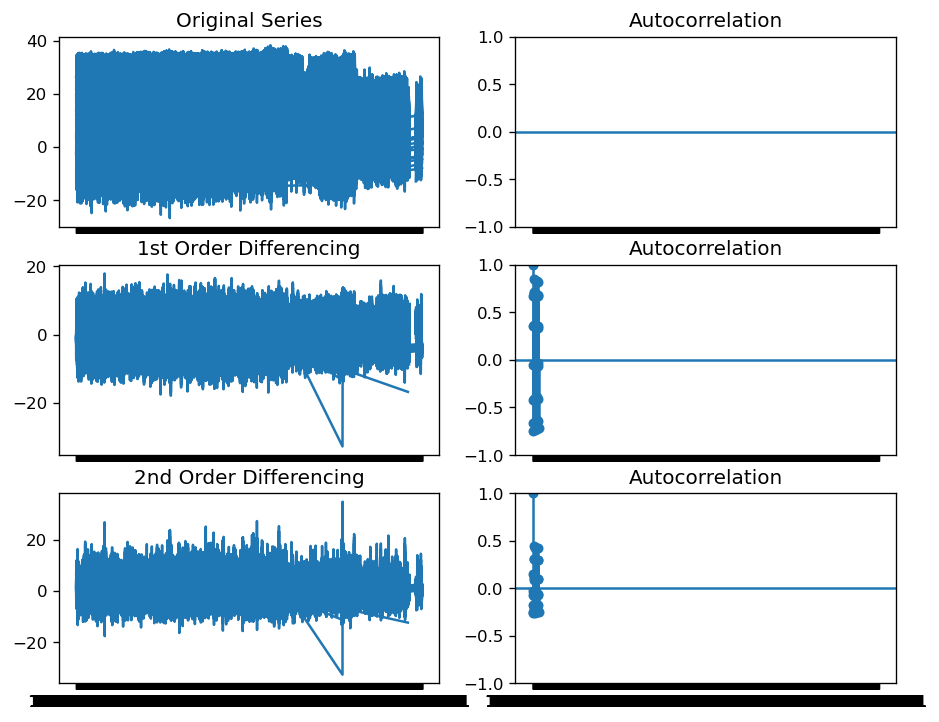

In [7]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df["AverageTemperature"]); axes[0, 0].set_title('Original Series')
plot_acf(df["AverageTemperature"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["AverageTemperature"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["AverageTemperature"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["AverageTemperature"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["AverageTemperature"].diff().diff().dropna(), ax=axes[2, 1])
plt.show()

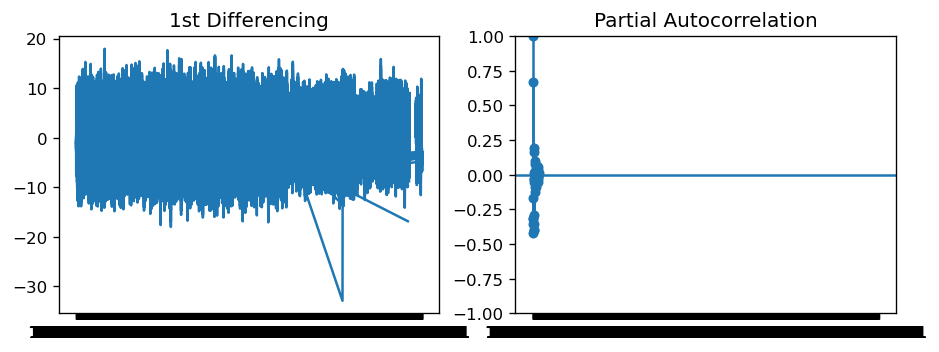

In [6]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df["AverageTemperature"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df["AverageTemperature"].diff().dropna(), ax=axes[1])

plt.show()

At the start of the Autocorrelation , we observe the negative value, meaning that very quickly seris are over differenciate.
In that situation we can't expect of lot from model. To be short we are in underfitting situation.
Graphics are not really clear. Anyway let's the ARIMA model, hoping we can observe some trends

In [14]:


# 1,1,1 ARIMA Model
df.index = pd.DatetimeIndex(df.index).to_period('M')

model_fit= ARIMA(df["AverageTemperature"], order=(1,1,1)).fit()
print(model_fit.summary())


/home/kngadi/miniforge3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kngadi/miniforge3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kngadi/miniforge3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:               239177
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -556305.594
Date:                Sat, 17 Feb 2024   AIC                        1112617.187
Time:                        05:09:58   BIC                        1112648.342
Sample:                             0   HQIC                       1112626.286
                             - 239177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6077      0.002    306.599      0.000       0.604       0.612
ma.L1          0.1185      0.002     50.930      0.000       0.114       0.123
sigma2         7.6028      0.016    480.451      0.0

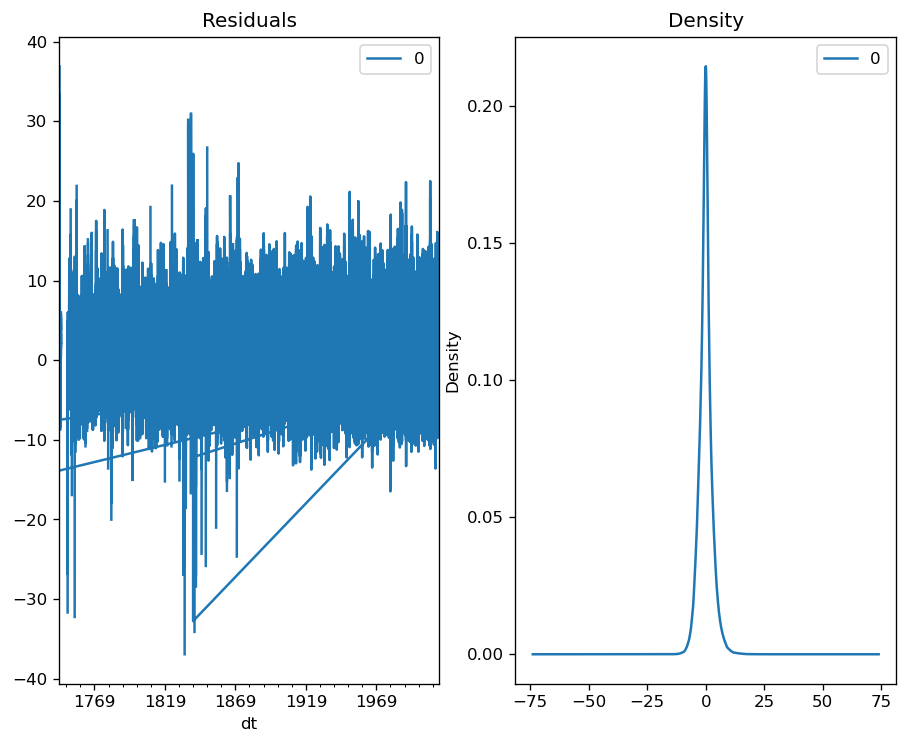

In [15]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

As we said before, result are not very fun. 

The residual errors seem with near zero mean but  without uniform variance.

 Let’s plot the actuals against the fitted values using plot_predict().

In [16]:
latest_df[['Avg_temp']].resample('A').mean()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1849-01,26.703125,1.434570,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02,27.437500,1.362305,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03,28.093750,1.612305,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04,26.140625,1.386719,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05,25.421875,1.200195,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...
2013-05,18.984375,0.807129,Xian,China,34.56N,108.97E
2013-06,23.515625,0.646973,Xian,China,34.56N,108.97E
2013-07,25.250000,1.041992,Xian,China,34.56N,108.97E


/home/kngadi/miniforge3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


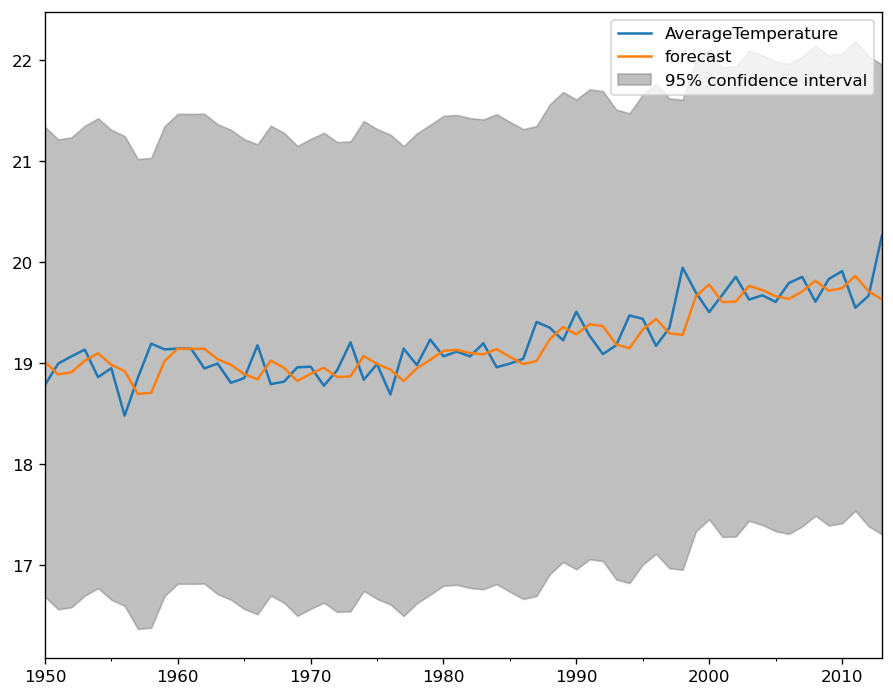

In [17]:
dta = df[["AverageTemperature"]].resample('A').mean()
dta.index = pd.date_range(start='1743', end='2014', freq='A')
res = ARIMA(dta, order=(1,1,1)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1950', '2013', ax=ax)
plt.show()

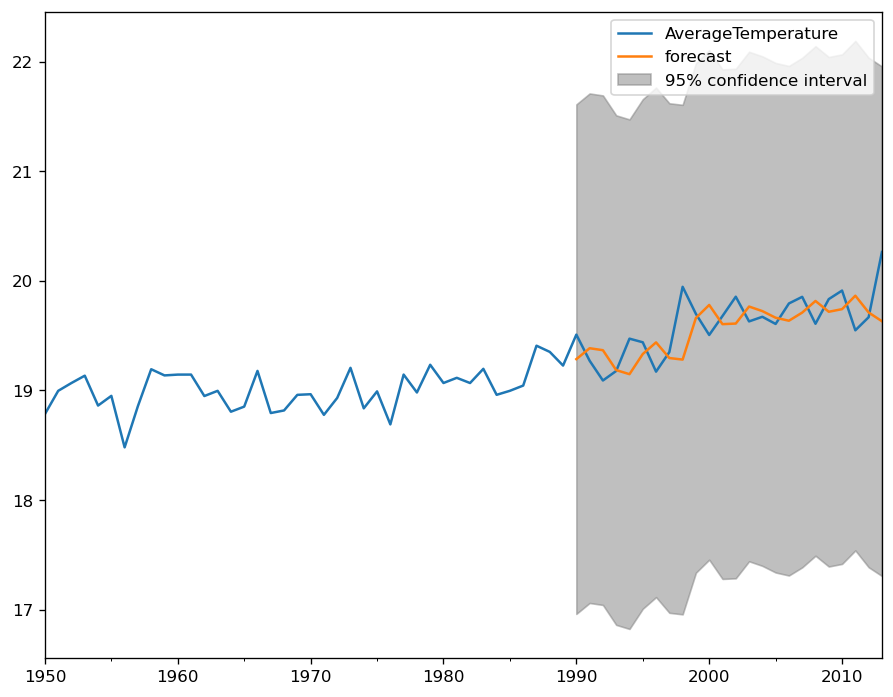

In [23]:
ig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1990', '2013', ax=ax)
plt.show()

.
We confirm again the prior intuition namely our forecasting is not fun. 
Also it is on a few part of data to be visualizable.
To fix idea let's have a look on some metrics 

In [19]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = dta[:178]
test = dta[178:]

In [29]:
fc.values.shape

(93,)

In [24]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()
fc = fitted.forecast(93, alpha=0.05)

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  178
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -312.022
Date:                Sat, 17 Feb 2024   AIC                            630.044
Time:                        05:24:28   BIC                            639.573
Sample:                    12-31-1743   HQIC                           633.909
                         - 12-31-1920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3553      0.201     -1.770      0.077      -0.749       0.038
ma.L1         -0.1082      0.223     -0.486      0.627      -0.544       0.328
sigma2         2.1414      0.083     25.700      0.0

/home/kngadi/miniforge3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kngadi/miniforge3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [32]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, test["AverageTemperature"].values)

{'mape': 0.02161441774622115,
 'me': -0.4084736110587618,
 'mae': 0.41926500406016776,
 'mpe': -0.021033224623716432,
 'rmse': 0.5414159411667488,
 'corr': -0.061856468427492414,
 'minmax': 0.021612211362910694}